In [127]:
import requests
import torch
import numpy as np
from PIL import Image, ImageOps
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms, datasets
import torchvision
from io import BytesIO
import cv2

In [93]:
model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

In [94]:
def load_model(model_path, num_classes):
    model = torchvision.models.resnet50(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [95]:
def leaf_classification(image_crop, model, transform, class_labels):
    # Apply the transformation
    image_tensor = transform(image_crop).unsqueeze(0)
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.sigmoid(outputs).numpy().flatten()
        highest_prob = np.max(probs)
        highest_class = class_labels[np.argmax(probs)]
    return highest_class, highest_prob

In [70]:
def to_grayscale(image):
    grayscale_image = image.convert("L")
    grayscale_image = np.stack([np.array(grayscale_image)]*3, axis=-1)
    return Image.fromarray(grayscale_image)

In [129]:
def make_square(image, min_size=224, fill_color=(255, 255, 255)):
    x, y = image.size
    size = max(min_size, x, y)
    new_image = Image.new('RGB', (size, size), fill_color)
    new_image.paste(image, ((size - x) // 2, (size - y) // 2))
    return new_image

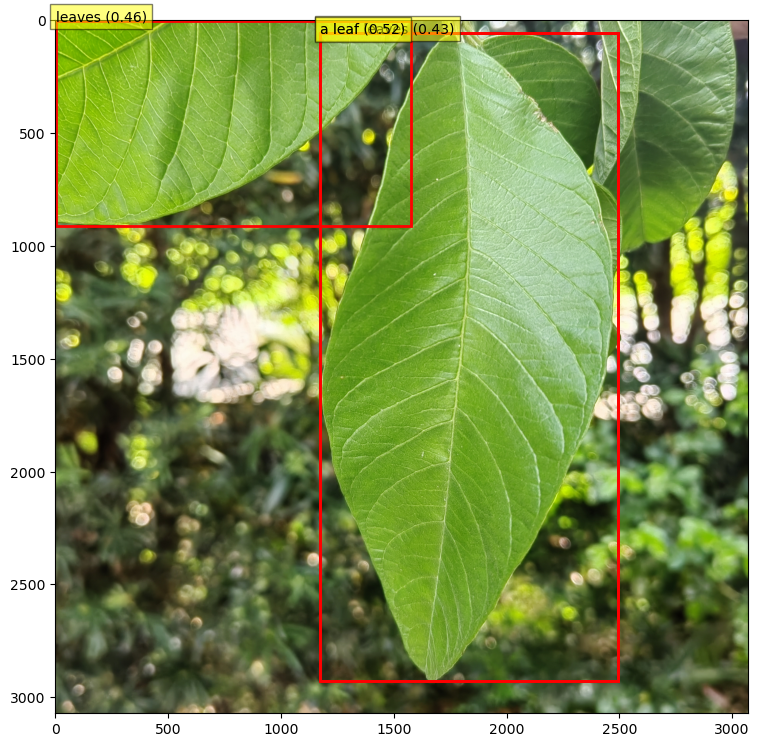

Detected a leaf leaves with score 0.43. Classified as Bayabas with confidence 0.70


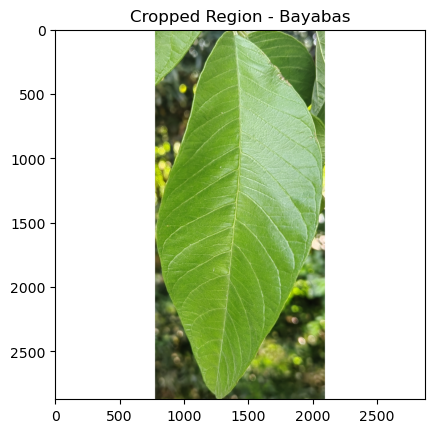

Detected leaves with score 0.46. Classified as Balayong with confidence 0.86


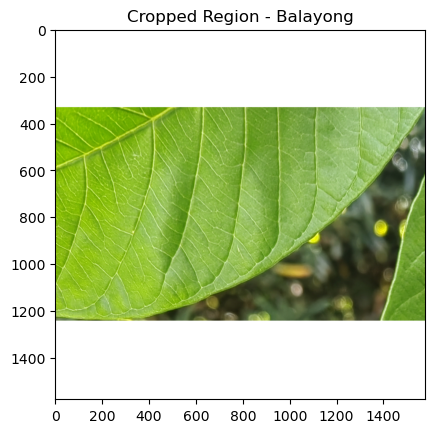

Detected a leaf with score 0.52. Classified as Bayabas with confidence 0.71


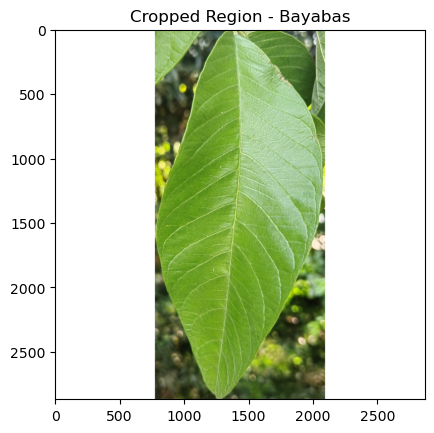

In [137]:
if __name__ == "__main__":
    model_id = "IDEA-Research/grounding-dino-tiny"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

    model_path = 'final_model.pth'
    class_labels = ['Apitong', 'Balayong', 'Balete', 'Bayabas', 'Guyabano']
    leaf_model = load_model(model_path, num_classes=len(class_labels)).to(device)
    leaf_model.eval()  
    data_transforms = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.Lambda(to_grayscale),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image_path = r"E:\Samples\Snapfolia\Samples\splitted_dataS\test\Bayabas\Bayabas C (15).jpg"
    image = Image.open(image_path).convert('RGB')
    
#     image_url = 'https://down-ph.img.susercontent.com/file/f15ec7a394514961c4487ec9da1535e2'
#     image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    
    inputs = processor(images=image, text="a leaf. leaves.", return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.4,
        text_threshold=0.3,
        target_sizes=[image.size[::-1]]
    )

    if results and "boxes" in results[0] and results[0]["boxes"].shape[0] > 0:
        visualize_detection(image, results)

        for result in results:
            for box, label, score in zip(result["boxes"], result["labels"], result["scores"]):
                box = box.cpu().numpy()
                x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
                cropped_image = image.crop((x1, y1, x2, y2))
                
                # Make the cropped image square with padding
                cropped_image_square = make_square(cropped_image)

                cropped_image_transformed = data_transforms(cropped_image_square).unsqueeze(0).to(device)
                with torch.no_grad():
                    logits = leaf_model(cropped_image_transformed)
                confidence, predicted_class = torch.max(torch.nn.functional.softmax(logits, dim=1), dim=1)
                leaf_type = class_labels[predicted_class.item()]
                confidence = confidence.item()
                
                print(f"Detected {label} with score {score:.2f}. Classified as {leaf_type} with confidence {confidence:.2f}")

                # Visualize the cropped region
                plt.figure()
                plt.imshow(cropped_image_square)
                plt.title(f"Cropped Region - {leaf_type}")
                plt.axis('on')
                plt.show()
    else:
        plt.figure()
        plt.imshow(image)
        plt.title("Original Image - No Leaf detected")
        plt.axis('on')
        plt.show()